In [583]:
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [659]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 8})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25

In [747]:
datadir = '/cellar/users/snwright/Data/RareCommon'
figdir = '/cellar/users/snwright/Data/Transfer/RVC/figures/GenomicLoci'

In [375]:
rv_gda = pd.read_csv(os.path.join(datadir, 'RAVAR', 'gene_fulltable_06112024.txt.loci'), sep='\t', low_memory=False, index_col=0)
cv_gda = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt.cleanedFeb19'), sep='\t', low_memory=False).dropna(subset=['SNP_ID_CURRENT'])
cv_gda = cv_gda.assign(rsID = cv_gda.SNP_ID_CURRENT.apply(lambda x: 'rs' + str(int(x)) if isinstance(x, float) else 'rs' + x if isinstance(x, str) else x)) 

In [390]:
rv_traits = pd.read_csv(os.path.join(datadir, 'inputs/Jan_2025', 'rare.traitlist'), header=None, names=['TraitR'])
cv_traits = pd.read_csv(os.path.join(datadir, 'inputs/Jan_2025', 'common.traitlist'), header=None, names=['TraitC'])
trait_pairs = pd.concat([rv_traits, cv_traits], axis=1)
trait_pairs['StudyR'] = trait_pairs.TraitR.apply(lambda x: float(x.split('_')[0]))
trait_pairs['StudyC'] = trait_pairs.TraitC.apply(lambda x: x.split('_')[0])
trait_pairs['EFO'] = trait_pairs.TraitC.apply(lambda x: x.split('_', 1)[-1])
trait_pairs.head()

,TraitR,TraitC,StudyR,StudyC,EFO
0,34375979.0_EFO_0004631,GCST90000618_EFO_0004631,34375979.0,GCST90000618,EFO_0004631
1,34375979.0_MONDO_0002009,GCST009979_MONDO_0002009,34375979.0,GCST009979,MONDO_0002009
2,34375979.0_EFO_0020690,GCST90239636_EFO_0020690,34375979.0,GCST90239636,EFO_0020690
3,34375979.0_EFO_0004193,GCST90013410_EFO_0004193,34375979.0,GCST90013410,EFO_0004193
4,30206357.0_EFO_0004842,GCST90002302_EFO_0004842,30206357.0,GCST90002302,EFO_0004842


In [607]:
rv_only = trait_pairs.drop_duplicates(subset='TraitR')
cv_only = trait_pairs.drop_duplicates(subset='TraitC')

# Loci overlap v2

In [610]:
def get_rv_intervals2(rv_gda, study, trait, id_col='Ensembl ID', chr_col='Chromosome', start_col='Start', 
                     end_col='End', window=50000):
    assoc = rv_gda[(rv_gda.TRAIT_CODE==trait) & (rv_gda.PMID == study)].drop_duplicates(subset=[id_col])
    all_intervals = {}
    chr_counts = assoc[chr_col].value_counts()
    for CHR in chr_counts.index.values:
        chr_assoc = assoc[assoc[chr_col]==CHR].sort_values(by=start_col)
        intervals = [[start, end] for start, end in zip(chr_assoc.Start, chr_assoc.End)]
        all_intervals[CHR] = intervals
    return all_intervals

In [611]:
rv_intervals2 = {}
for trow in tqdm(rv_only.iterrows()):
    rv_intervals2[trow[1]['TraitR']] = get_rv_intervals2(rv_gda, trow[1]['StudyR'], trow[1]['EFO'], window=50000)

529it [00:04, 114.66it/s]


In [ ]:
def find_snp_matches(intervals, snp_df):
    res = []
    for CHR, ranges in intervals.items():
        chr_df = snps_in_intervals(intervals[CHR],snp_df[snp_df['chr38']==f'chr{CHR}'])
        chr_df['Chromosome'] = CHR
        res.append(chr_df)
    return pd.concat(res)
    

def snps_in_intervals(intervals, snp_df):
    """
    For each interval in a list of intervals, assess whether any SNP positions
    (given in the 'pos38' column of snp_df) fall within the interval.
    
    Parameters:
      intervals (list of lists): A list of intervals, where each interval is 
                                 [start, end].
      snp_df (pd.DataFrame): DataFrame containing a column 'pos38' with SNP positions.
    
    Returns:
      pd.DataFrame: A DataFrame with columns 'start', 'end', and 'match', where 'match'
                    is True if any SNP falls within the interval, otherwise False.
    """
    # Convert the SNP positions to a sorted NumPy array for efficient searching.
    snp_positions = np.sort(snp_df['pos38'].to_numpy())
    
    results = []
    if len(snp_df) == 0:
        for start, end in intervals:
            results.append({'start': start, 'end': end, 'match': False}) 
    else: 
        for start, end in intervals:
            # Find the index of the first SNP >= start
            left_idx = np.searchsorted(snp_positions, start, side='left')
            # Find the index of the first SNP > end
            right_idx = np.searchsorted(snp_positions, end, side='right')

            # If left_idx is less than right_idx, there is at least one SNP in the interval.
            match = left_idx < right_idx
            results.append({'start': start, 'end': end, 'match': match})
    return pd.DataFrame(results)


In [612]:
overlapping_loci = []
for i, pair in tqdm(enumerate(trait_pairs.iterrows())):
    snp_df = cv_gda[(cv_gda['STUDY ACCESSION']==pair[1]['StudyC']) & (cv_gda['TRAIT_CODE']==pair[1]['EFO'])].drop_duplicates(subset='rsID')
    snp_df = snp_df.merge(all_snps, right_index=True, left_on='rsID', how='left').drop_duplicates(subset=['rsID'])
    pair_df = find_snp_matches(rv_intervals2[pair[1]['TraitR']], snp_df)
    pair_df['TraitR'] = pair[1]['TraitR']
    pair_df['TraitC'] = pair[1]['TraitC']
    overlapping_loci.append(pair_df)
overlaps = pd.concat(overlapping_loci)

1809it [02:03, 14.60it/s]


In [613]:
overlap_counts = overlaps.sort_values(['Chromosome', 'start']).groupby(['TraitR', 'TraitC']).match.value_counts().reset_index().pivot_table(index=['TraitR', 'TraitC'], values='count', columns='match', fill_value=0).reset_index()

In [614]:
overlap_counts.columns = ['TraitR', 'TraitC', 'NoMatch', 'Match']

In [615]:
rv_only_df.columns = ['GeneCount', 'RareLoci', 'RareSharedLoci']
cv_only_df.columns = ['SNPCount', 'CommonLoci', 'CommonSharedLoci']

In [616]:
overlap_df = overlap_counts.merge(rv_only_df, left_on='TraitR', right_index=True, how='outer')
overlap_df = overlap_df.merge(cv_only_df, left_on='TraitC', right_index=True, how='outer')

In [617]:
overlap_df['trait_pair'] = overlap_df['TraitR'] + '_' + overlap_df['TraitC']

In [618]:
(overlap_df['Match'] / (overlap_df['Match']+overlap_df['NoMatch'])).describe()

count    1777.000000
mean        0.107183
std         0.174532
min         0.000000
25%         0.000000
50%         0.000000
75%         0.187500
max         1.000000
dtype: float64

In [619]:
hgeom_df = pd.read_csv('/cellar/users/snwright/Data/RareCommon/outputs/overlap/rvc_overlap_results_Jan_2025.txt', sep='\t',
                     header=None, names=['trait_pair', 'param_set', 'n_common', 'n_rare', 'n_overlap', 'background', 'pval'])
import re
def map_trait_code(code):
    efo = next((match.group() for match in re.finditer(r'EFO_\d+', code)), None)
    if efo is not None:
        return efo
    mondo = next((match.group() for match in re.finditer(r'MONDO_\d+', code)), None)
    if mondo is not None:
        return mondo
    hp = next((match.group() for match in re.finditer(r'HP_\d+', code)), None)
    if hp is not None:
        return hp
    go = next((match.group() for match in re.finditer(r'GO_\d+', code)), None)
    if go is not None:
        return go
    return None
hgeom_df['EFO'] = hgeom_df.trait_pair.apply(lambda x: map_trait_code(x))
hgeom_df['StudyC'] = hgeom_df.trait_pair.apply(lambda x: next((match.group() for match in re.finditer(r'GCST\d+', x)), None))
hgeom_df['StudyR'] = hgeom_df.trait_pair.apply(lambda x: x.split('_')[0])

In [620]:
combo_df = hgeom_df.loc[:, ('trait_pair', 'n_rare', 'n_overlap',)].merge(overlap_df.loc[:, ('trait_pair', 'RareLoci', 'Match', 'TraitR', 'TraitC')], on='trait_pair')

In [621]:
combo_df['Gene'] = combo_df['n_overlap']/combo_df['n_rare']
combo_df['Loci'] = combo_df['Match']/combo_df['RareLoci']

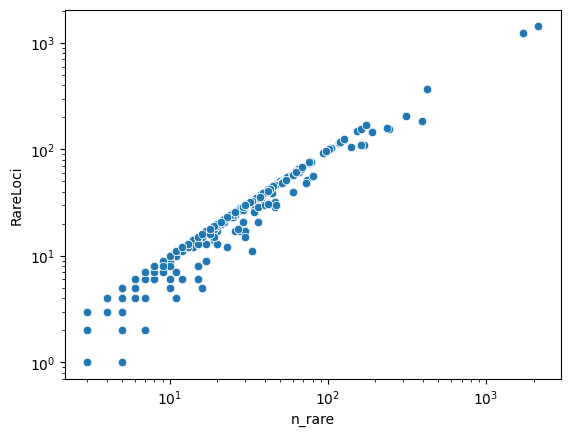

In [622]:
sns.scatterplot(combo_df, x='n_rare', y='RareLoci')
plt.yscale('log')
plt.xscale('log')

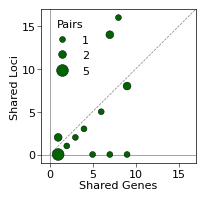

In [748]:
_ = plt.figure(figsize=(2,2))
plot_df = combo_df[combo_df.Match != combo_df.n_overlap].groupby(['n_overlap', 'Match']).trait_pair.nunique().reset_index()
plot_df.rename(columns={'trait_pair': 'Pairs'}, inplace=True)

plt.plot(range(0, 18), range(0, 18), color='grey', linestyle='--', linewidth=0.5)
plt.hlines(y=0, xmin=-1, xmax=18, color='grey', linewidth=0.5,)
plt.vlines(x=0, ymin=-1, ymax=18, color='grey', linewidth=0.5,)
sns.scatterplot(plot_df, x='n_overlap', y='Match', size='Pairs',color='darkgreen', edgecolor='black', zorder=100)
plt.xlabel('Shared Genes')
plt.ylabel('Shared Loci')
plt.xlim(-1, 17)
plt.ylim(-1, 17)
plt.savefig(os.path.join(figdir, 'genomic_loci_scatter.svg'), bbox_inches='tight')

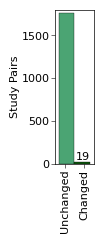

In [749]:
_ = plt.figure(figsize=(0.5,2))
plot_df = pd.DataFrame({'Count': [len(combo_df[combo_df.Match == combo_df.n_overlap]),  len(combo_df[combo_df.Match != combo_df.n_overlap])], 
                         'x': [1,1], 'Group':['Unchanged', 'Changed']})
sns.barplot(plot_df, x='x', y='Count', hue='Group',legend=False, 
           palette=['mediumseagreen', 'darkgreen'], edgecolor='black')
#_ = plt.text(x=-0.4, y=plot_df[plot_df.Group=='Unchanged'].Count.values+25, s=str(plot_df[plot_df.Group=='Unchanged'].Count.values[0]), rotation=45)
_ = plt.text(x=0.05, y=plot_df[plot_df.Group=='Changed'].Count.values+25, s=str(plot_df[plot_df.Group=='Changed'].Count.values[0]))
plt.ylim(0,1800)
plt.ylabel('Study Pairs')
plt.xticks([-0.25, 0.25], ['Unchanged', 'Changed'], rotation=90)
plt.xlabel('')
plt.savefig(os.path.join(figdir, 'genomic_loci_bar.svg'), bbox_inches='tight')

In [750]:
19/(1758+19)

0.010692177827799663

(-1.0, 20.0)

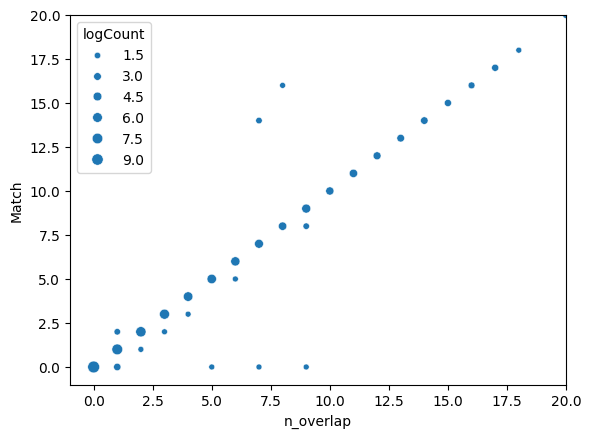

In [650]:
plot_df = combo_df.groupby(['n_overlap', 'Match']).trait_pair.nunique().reset_index()
plot_df['logCount'] = np.log2(plot_df['trait_pair'] + 1)
sns.scatterplot(plot_df, x='n_overlap', y='Match', size='logCount')
plt.xlim(-1,20)
plt.ylim(-1,20)

In [624]:
combo_df

,trait_pair,n_rare,n_overlap,RareLoci,Match,TraitR,TraitC,Gene,Loci
0,19847924.0_EFO_0001645_GCST005195_EFO_0001645,6,0,6,0.0,19847924.0_EFO_0001645,GCST005195_EFO_0001645,0.0,0.0
1,19847924.0_EFO_0001645_GCST008370_EFO_0001645,6,0,6,0.0,19847924.0_EFO_0001645,GCST008370_EFO_0001645,0.0,0.0
2,19847924.0_EFO_0001645_GCST010479_EFO_0001645,6,0,6,0.0,19847924.0_EFO_0001645,GCST010479_EFO_0001645,0.0,0.0
3,19847924.0_EFO_0001645_GCST90132315_EFO_0001645,6,0,6,0.0,19847924.0_EFO_0001645,GCST90132315_EFO_0001645,0.0,0.0
4,19847924.0_EFO_0001645_GCST90449059_EFO_0001645,6,0,6,0.0,19847924.0_EFO_0001645,GCST90449059_EFO_0001645,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1772,37301943.0_EFO_0006941_GCST005829_EFO_0006941,30,0,30,0.0,37301943.0_EFO_0006941,GCST005829_EFO_0006941,0.0,0.0
1773,37301943.0_EFO_0006941_GCST005830_EFO_0006941,30,0,30,0.0,37301943.0_EFO_0006941,GCST005830_EFO_0006941,0.0,0.0
1774,37301943.0_EFO_0006941_GCST90007526_EFO_0006941,30,0,30,0.0,37301943.0_EFO_0006941,GCST90007526_EFO_0006941,0.0,0.0
1775,37301943.0_EFO_0006941_GCST90095048_EFO_0006941,30,0,30,0.0,37301943.0_EFO_0006941,GCST90095048_EFO_0006941,0.0,0.0


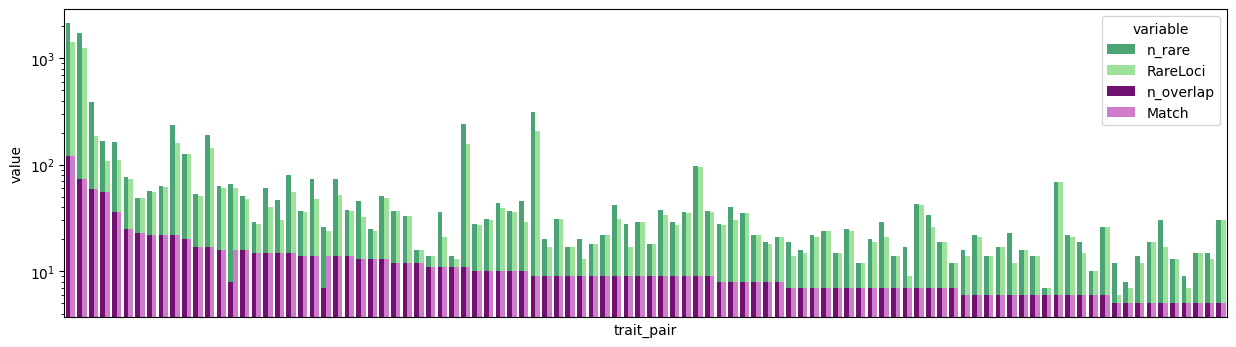

In [626]:
_ = plt.figure(figsize=(15, 4))
sns.barplot(combo_df.sort_values('Match', ascending=False).drop_duplicates(subset=['TraitR'])[0:100].melt(id_vars=['trait_pair'], value_vars=['n_rare', 'RareLoci']), 
            x='trait_pair', y='value', hue='variable', palette=['mediumseagreen', 'lightgreen'], hue_order=['n_rare', 'RareLoci'])
sns.barplot(combo_df.sort_values('Match', ascending=False).drop_duplicates(subset=['TraitR'])[0:100].melt(id_vars=['trait_pair'], value_vars=['n_overlap', 'Match']), 
            x='trait_pair', y='value', hue='variable', 
            palette=['purple', 'orchid'], hue_order=['n_overlap', 'Match'])
plt.xticks([])
plt.yscale('log')

# Loci overlap v1

In [562]:
(rv_gda['End'] - rv_gda['Start']).describe()

count    7.627800e+04
mean     7.186642e+04
std      1.164192e+05
min      7.900000e+01
25%      1.312000e+04
50%      3.421400e+04
75%      8.382825e+04
max      2.473538e+06
dtype: float64

In [565]:
8.382825e+04

83828.25

## Overlapping RV loci

In [393]:
rv_only = trait_pairs.drop_duplicates(subset='TraitR')

In [452]:
rv_only_overlap = {'GeneCount':{}, 'LociCount': {}}
for trow in rv_only.iterrows():
    gene, loci = get_rv_interval_counts(rv_gda, trow[1]['StudyR'], trow[1]['EFO'], window=50000)
    rv_only_overlap['GeneCount'][trow[1]['TraitR']] = gene
    rv_only_overlap['LociCount'][trow[1]['TraitR']] = loci
rv_only_df = pd.DataFrame(rv_only_overlap)
rv_only_df['SharedLoci'] = rv_only_df['GeneCount']-rv_only_df['LociCount']

In [455]:
def collapse_gene_regions(df, window):
    """
    Collapses overlapping gene regions (extended by the given window) into a single region and
    returns the total number of distinct regions along with their bounds.
    
    Parameters:
      df (pd.DataFrame): DataFrame with three columns: 
                         'gene' (gene identifier), 'start' (start position), 'end' (end position).
      window (int or float): The window size to extend each region on either side.
    
    Returns:
      tuple: A tuple (num_regions, merged_intervals) where:
             - num_regions (int): The number of collapsed regions.
             - merged_intervals (list of lists): Each sublist contains [start, end] bounds of a merged region.
    """
    # Create effective intervals by extending each region
    df = df.copy()
    df['eff_start'] = df['Start'] - window
    df['eff_end'] = df['End'] + window

    # Sort intervals by the effective start position
    df = df.sort_values('eff_start')
    
    # List to store merged intervals
    merged_intervals = []
    
    # Iterate through each effective interval
    for _, row in df.iterrows():
        current_start, current_end = row['eff_start'], row['eff_end']
        
        # If there are no intervals yet, add the first one
        if not merged_intervals:
            merged_intervals.append([current_start, current_end])
        else:
            # Get the last merged interval
            last_interval = merged_intervals[-1]
            # If current interval overlaps with the last one, merge them
            if current_start <= last_interval[1]:
                last_interval[1] = max(last_interval[1], current_end)
            else:
                # No overlap, so add this as a new interval
                merged_intervals.append([current_start, current_end])
    
    return merged_intervals


def get_rv_interval_counts(rv_gda, study, trait, id_col='Ensembl ID', chr_col='Chromosome', start_col='Start', 
                     end_col='End', window=50000):
    assoc = rv_gda[(rv_gda.TRAIT_CODE==trait) & (rv_gda.PMID == study)].drop_duplicates(subset=[id_col])
    gene_count = len(assoc)
    loci_count = 0
    chr_counts = assoc[chr_col].value_counts()
    single_gene_chr = chr_counts[chr_counts == 1].index.values
    loci_count += len(single_gene_chr)
    multiple_gene_chr = chr_counts[chr_counts > 1].index.values
    if len(multiple_gene_chr) > 0:
        for CHR in multiple_gene_chr:
            chr_assoc = assoc[assoc[chr_col]==CHR].sort_values(by=start_col)
            intervals = collapse_gene_regions(chr_assoc, window=50000)
            loci_count += len(intervals)
    return gene_count, loci_count


## Overlapping CV loci

In [418]:
cv_only = trait_pairs.drop_duplicates(subset='TraitC')
cv_only.head(2)

,TraitR,TraitC,StudyR,StudyC,EFO
0,34375979.0_EFO_0004631,GCST90000618_EFO_0004631,34375979.0,GCST90000618,EFO_0004631
1,34375979.0_MONDO_0002009,GCST009979_MONDO_0002009,34375979.0,GCST009979,MONDO_0002009


In [419]:
cv_gda.head(1)

,PUBMEDID,DATE,DISEASE/TRAIT,MAPPED_GENE,SNP_GENE_IDS,SNP_ID_CURRENT,INTERGENIC,P-VALUE,OR or BETA,MAPPED_TRAIT,MAPPED_TRAIT_URI,STUDY ACCESSION,TRAIT_CODE,rsID
0,25673412,2015-02-12,Hip circumference adjusted for BMI,TSEN15,ENSG00000198860,1046934.0,0.0,6.000000e-10,0.0232,BMI-adjusted hip circumference,http://www.ebi.ac.uk/efo/EFO_0008039,GCST004067,EFO_0008039,rs1046934


In [447]:
cv_only_overlap = {'SNPCount':{}, 'LociCount': {}}
for i, trow in enumerate(cv_only.iterrows()):
    snp, loci = get_cv_interval_counts(cv_gda, trow[1]['StudyC'], trow[1]['EFO'], window=50000)
    cv_only_overlap['SNPCount'][trow[1]['TraitC']] = snp
    cv_only_overlap['LociCount'][trow[1]['TraitC']] = loci
cv_only_df = pd.DataFrame(cv_only_overlap)
cv_only_df['SharedLoci'] = cv_only_df['SNPCount']-cv_only_df['LociCount']

In [453]:
cv_only_df[cv_only_df.SharedLoci==1009]

,SNPCount,LociCount,SharedLoci
GCST90027168_HP_0000023,1049,40,1009


In [456]:
def get_cv_interval_counts(cv_gda, study, trait, id_col='rsID', chr_col='chr38', pos_col='pos38', window=50000):
    assoc = cv_gda[(cv_gda['STUDY ACCESSION']==study) & (cv_gda['TRAIT_CODE']==trait)].drop_duplicates(subset=id_col)
    assoc = assoc.merge(all_snps, right_index=True, left_on=id_col, how='left').drop_duplicates(subset=[id_col])
    snp_count =len(assoc)
    loci_count = 0
    chr_counts = assoc[chr_col].value_counts()
    single_gene_chr = chr_counts[chr_counts == 1].index.values
    loci_count += len(single_gene_chr)
    multiple_gene_chr = chr_counts[chr_counts > 1].index.values
    if len(multiple_gene_chr) > 0:
        for CHR in multiple_gene_chr:
            chr_assoc = assoc[assoc[chr_col]==CHR].sort_values(by=pos_col)
            intervals = collapse_positions(chr_assoc, window=window)
            loci_count += len(intervals)
    return snp_count, loci_count

def get_cv_intervals(cv_gda, study, trait, id_col='rsID', chr_col='chr38', pos_col='pos38', window=50000):
    assoc = cv_gda[(cv_gda['STUDY ACCESSION']==study) & (cv_gda['TRAIT_CODE']==trait)].drop_duplicates(subset=id_col)
    assoc = assoc.merge(all_snps, right_index=True, left_on=id_col, how='left').drop_duplicates(subset=[id_col])
    all_intervals = {}
    chr_counts = assoc[chr_col].value_counts()
    for CHR in chr_counts.index.values:
        chr_assoc = assoc[assoc[chr_col]==CHR].sort_values(by=pos_col)
        intervals = collapse_positions(chr_assoc, window=window)
        all_intervals[CHR] = intervals
    return all_intervals


def collapse_positions(df, window):
    """
    Collapse individual positions into intervals if they are within the given window distance.

    For positions that are close enough (i.e. the gap between successive positions is less than or equal
    to the window), the function groups them into a merged interval. If only one position is present in
    a group, that position is returned as is.

    Parameters:
      df (pd.DataFrame): A DataFrame with a single column 'position' containing numeric positions.
      window (int or float): The maximum allowed gap between positions to consider them part of the same group.

    Returns:
      list: A list where each element is either a single position (if isolated) or a tuple (start, end)
            representing the merged interval of positions.
    """
    # Sort the positions in ascending order.
    positions = sorted(df['pos38'])
    if not positions:
        return []
    
    merged = []
    # Initialize the first group with the first position.
    current_start = positions[0]
    current_end = positions[0]
    group_count = 1  # To track how many positions are in the current group.

    for pos in positions[1:]:
        # If the gap between the current position and the last one in the group is within the window,
        # include it in the group.
        if pos - current_end <= window:
            current_end = pos  # Extend the group to include the new position.
            group_count += 1
        else:
            # Finalize the current group.
            if group_count == 1:
                merged.append(current_start)
            else:
                merged.append((current_start, current_end))
            # Start a new group with the current position.
            current_start = pos
            current_end = pos
            group_count = 1

    # Append the final group.
    if group_count == 1:
        merged.append(current_start)
    else:
        merged.append((current_start, current_end))
    
    return merged

## Shared loci

In [ ]:
def get_rv_intervals(rv_gda, study, trait, id_col='Ensembl ID', chr_col='Chromosome', start_col='Start', 
                     end_col='End', window=50000):
    assoc = rv_gda[(rv_gda.TRAIT_CODE==trait) & (rv_gda.PMID == study)].drop_duplicates(subset=[id_col])
    all_intervals = {}
    chr_counts = assoc[chr_col].value_counts()
    for CHR in chr_counts.index.values:
        chr_assoc = assoc[assoc[chr_col]==CHR].sort_values(by=start_col)
        intervals = collapse_gene_regions(chr_assoc, window=50000)
        all_intervals[CHR] = intervals
    return all_intervals

In [550]:
def find_snp_matches(intervals, snp_df):
    res = []
    for CHR, ranges in intervals.items():
        chr_df = snps_in_intervals(intervals[CHR],snp_df[snp_df['chr38']==f'chr{CHR}'])
        chr_df['Chromosome'] = CHR
        res.append(chr_df)
    return pd.concat(res)
    

def snps_in_intervals(intervals, snp_df):
    """
    For each interval in a list of intervals, assess whether any SNP positions
    (given in the 'pos38' column of snp_df) fall within the interval.
    
    Parameters:
      intervals (list of lists): A list of intervals, where each interval is 
                                 [start, end].
      snp_df (pd.DataFrame): DataFrame containing a column 'pos38' with SNP positions.
    
    Returns:
      pd.DataFrame: A DataFrame with columns 'start', 'end', and 'match', where 'match'
                    is True if any SNP falls within the interval, otherwise False.
    """
    # Convert the SNP positions to a sorted NumPy array for efficient searching.
    snp_positions = np.sort(snp_df['pos38'].to_numpy())
    
    results = []
    if len(snp_df) == 0:
        for start, end in intervals:
            results.append({'start': start, 'end': end, 'match': False}) 
    else: 
        for start, end in intervals:
            # Find the index of the first SNP >= start
            left_idx = np.searchsorted(snp_positions, start, side='left')
            # Find the index of the first SNP > end
            right_idx = np.searchsorted(snp_positions, end, side='right')

            # If left_idx is less than right_idx, there is at least one SNP in the interval.
            match = left_idx < right_idx
            results.append({'start': start, 'end': end, 'match': match})
    return pd.DataFrame(results)


In [457]:
rv_intervals = {}
for trow in tqdm(rv_only.iterrows()):
    rv_intervals[trow[1]['TraitR']] = get_rv_intervals(rv_gda, trow[1]['StudyR'], trow[1]['EFO'], window=50000)

529it [00:08, 62.42it/s]


In [551]:
overlapping_loci = []
for i, pair in tqdm(enumerate(trait_pairs.iterrows())):
    snp_df = cv_gda[(cv_gda['STUDY ACCESSION']==pair[1]['StudyC']) & (cv_gda['TRAIT_CODE']==pair[1]['EFO'])].drop_duplicates(subset='rsID')
    snp_df = snp_df.merge(all_snps, right_index=True, left_on='rsID', how='left').drop_duplicates(subset=['rsID'])
    pair_df = find_snp_matches(rv_intervals[pair[1]['TraitR']], snp_df)
    pair_df['TraitR'] = pair[1]['TraitR']
    pair_df['TraitC'] = pair[1]['TraitC']
    overlapping_loci.append(pair_df)
overlaps = pd.concat(overlapping_loci)

1809it [02:03, 14.63it/s]


In [553]:
overlap_counts = overlaps.sort_values(['Chromosome', 'start']).groupby(['TraitR', 'TraitC']).match.value_counts().reset_index().pivot_table(index=['TraitR', 'TraitC'], values='count', columns='match', fill_value=0).reset_index()

In [558]:
overlap_counts.columns = ['TraitR', 'TraitC', 'NoMatch', 'Match']

In [559]:
rv_only_df.columns = ['GeneCount', 'RareLoci', 'RareSharedLoci']
cv_only_df.columns = ['SNPCount', 'CommonLoci', 'CommonSharedLoci']

In [560]:
overlap_df = overlap_counts.merge(rv_only_df, left_on='TraitR', right_index=True, how='outer')
overlap_df = overlap_df.merge(cv_only_df, left_on='TraitC', right_index=True, how='outer')

In [574]:
overlap_df['trait_pair'] = overlap_df['TraitR'] + '_' + overlap_df['TraitC']

In [567]:
(overlap_df['Match'] / (overlap_df['Match']+overlap_df['NoMatch'])).describe()

count    1777.000000
mean        0.142797
std         0.213613
min         0.000000
25%         0.000000
50%         0.000000
75%         0.250000
max         1.000000
dtype: float64

## combined counts

In [569]:
hgeom_df = pd.read_csv('/cellar/users/snwright/Data/RareCommon/outputs/overlap/rvc_overlap_results_Jan_2025.txt', sep='\t',
                     header=None, names=['trait_pair', 'param_set', 'n_common', 'n_rare', 'n_overlap', 'background', 'pval'])
import re
def map_trait_code(code):
    efo = next((match.group() for match in re.finditer(r'EFO_\d+', code)), None)
    if efo is not None:
        return efo
    mondo = next((match.group() for match in re.finditer(r'MONDO_\d+', code)), None)
    if mondo is not None:
        return mondo
    hp = next((match.group() for match in re.finditer(r'HP_\d+', code)), None)
    if hp is not None:
        return hp
    go = next((match.group() for match in re.finditer(r'GO_\d+', code)), None)
    if go is not None:
        return go
    return None
hgeom_df['EFO'] = hgeom_df.trait_pair.apply(lambda x: map_trait_code(x))
hgeom_df['StudyC'] = hgeom_df.trait_pair.apply(lambda x: next((match.group() for match in re.finditer(r'GCST\d+', x)), None))
hgeom_df['StudyR'] = hgeom_df.trait_pair.apply(lambda x: x.split('_')[0])

In [595]:
combo_df = hgeom_df.loc[:, ('trait_pair', 'n_rare', 'n_overlap',)].merge(overlap_df.loc[:, ('trait_pair', 'RareLoci', 'Match', 'TraitR', 'TraitC')], on='trait_pair')

In [596]:
combo_df['Gene'] = combo_df['n_overlap']/combo_df['n_rare']
combo_df['Loci'] = combo_df['Match']/combo_df['RareLoci']

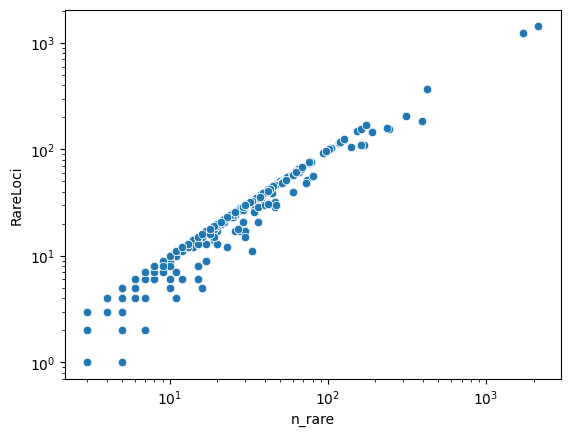

In [597]:
sns.scatterplot(combo_df, x='n_rare', y='RareLoci')
plt.yscale('log')
plt.xscale('log')

<Axes: xlabel='Gene', ylabel='Loci'>

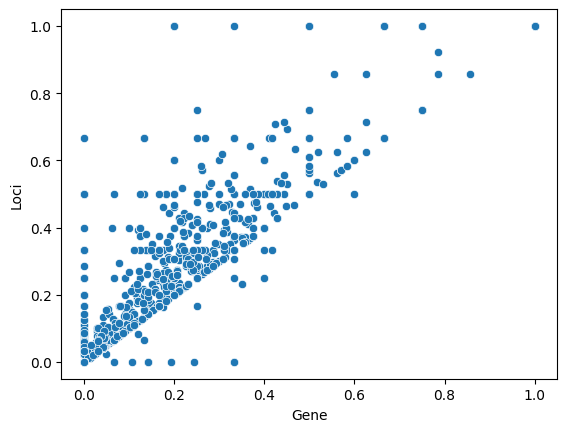

In [584]:
sns.scatterplot(combo_df, x='Gene', y='Loci')

In [594]:
combo_df

,trait_pair,n_rare,n_overlap,RareLoci,Match,Gene,Loci
0,19847924.0_EFO_0001645_GCST005195_EFO_0001645,6,0,6,0.0,0.0,0.000000
1,19847924.0_EFO_0001645_GCST008370_EFO_0001645,6,0,6,0.0,0.0,0.000000
2,19847924.0_EFO_0001645_GCST010479_EFO_0001645,6,0,6,0.0,0.0,0.000000
3,19847924.0_EFO_0001645_GCST90132315_EFO_0001645,6,0,6,0.0,0.0,0.000000
4,19847924.0_EFO_0001645_GCST90449059_EFO_0001645,6,0,6,1.0,0.0,0.166667
...,...,...,...,...,...,...,...
1772,37301943.0_EFO_0006941_GCST005829_EFO_0006941,30,0,30,1.0,0.0,0.033333
1773,37301943.0_EFO_0006941_GCST005830_EFO_0006941,30,0,30,1.0,0.0,0.033333
1774,37301943.0_EFO_0006941_GCST90007526_EFO_0006941,30,0,30,0.0,0.0,0.000000
1775,37301943.0_EFO_0006941_GCST90095048_EFO_0006941,30,0,30,0.0,0.0,0.000000


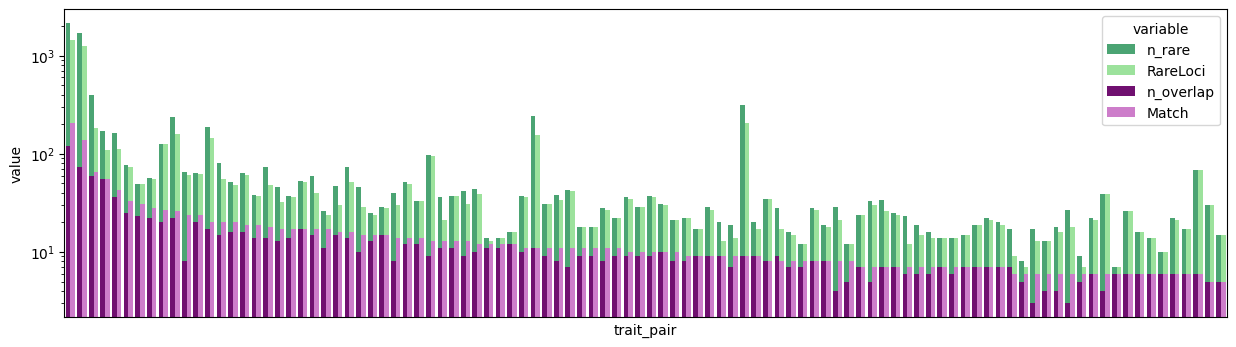

In [600]:
_ = plt.figure(figsize=(15, 4))
sns.barplot(combo_df.sort_values('Match', ascending=False).drop_duplicates(subset=['TraitR'])[0:100].melt(id_vars=['trait_pair'], value_vars=['n_rare', 'RareLoci']), 
            x='trait_pair', y='value', hue='variable', palette=['mediumseagreen', 'lightgreen'], hue_order=['n_rare', 'RareLoci'])
sns.barplot(combo_df.sort_values('Match', ascending=False).drop_duplicates(subset=['TraitR'])[0:100].melt(id_vars=['trait_pair'], value_vars=['n_overlap', 'Match']), 
            x='trait_pair', y='value', hue='variable', 
            palette=['purple', 'orchid'], hue_order=['n_overlap', 'Match'])
plt.xticks([])
plt.yscale('log')

# GENE MAPPING

In [280]:
## get all rv_gda genes (Entrez)
rv_gda = pd.read_csv(os.path.join(datadir, 'RAVAR', 'gene_fulltable_06112024.txt.entrez'), sep='\t')
all_genes = rv_gda.Entrez.unique()

In [281]:
## get gene positions from Ensembl (Entrez)
gene_df = pd.read_csv(os.path.join(datadir, 'Reference', 'Ensembl_Feb14_2025.txt.gz'), sep='\t', low_memory=False,
                     usecols=['Gene stable ID', 'Gene start (bp)', 'Gene end (bp)', 'Chromosome/scaffold name', 
                               'NCBI gene (formerly Entrezgene) ID']).drop_duplicates()
gene_df.columns = ['EnsemblID', 'GeneStart', 'GeneEnd', 'Chromosome', 'Entrez']


In [282]:
position_df = gene_df[gene_df.Entrez.isin(all_genes)]

In [283]:
## check if all genes have positions
mapped_entrez = gene_df[gene_df.Entrez.isin(all_genes)].Entrez.unique()
missing_genes = [gene for gene in all_genes if gene not in mapped_entrez]


In [284]:
missing_ensem = rv_gda[rv_gda.Entrez.isin(missing_genes)].drop_duplicates(subset=['Entrez', 'Ensembl ID']).loc[:, ('Ensembl ID', 'Entrez')]

In [285]:
missing_ensem = missing_ensem.merge(gene_df, left_on='Ensembl ID', right_on='EnsemblID', how='left', suffixes=('', '_y')).drop(columns=['Entrez_y', 'Ensembl ID'])

In [286]:
position_df = pd.concat([position_df, missing_ensem])

In [287]:
# restrict to those on primary chromosomes
position_df = position_df[(position_df.Chromosome.str.isnumeric()) | (position_df.Chromosome.isin(['X', 'Y','MT']))]

In [288]:
# genes without a primary chromosome mapping:
[x for x in all_genes if x not in position_df.Entrez.values]

[401289]

In [289]:
# manually add missing information
position_df = pd.concat([position_df, pd.DataFrame({'EnsemblID':['ENSG00000227508'], 'GeneStart':[170266624], 
                                                    'GeneEnd':[170279978], 'Chromosome':['6'], 'Entrez':[401289]})])

In [290]:
# use Ensembl ID as primary, fix any multiples - does this work though, not all had correct Ensembl. Need to
multiples = position_df.EnsemblID.value_counts()[position_df.EnsemblID.value_counts() > 1]

In [291]:
#corrections = {'ENSG00000111215': 11272, 'ENSG00000203668': 1122 ,'ENSG00000237541': 3118,  'ENSG00000257365':100529261 }
position_df[position_df.EnsemblID.isin(multiples.index.values)].sort_values('EnsemblID')

,EnsemblID,GeneStart,GeneEnd,Chromosome,Entrez
223958,ENSG00000111215,10845849,10849475,12,5554.0
223966,ENSG00000111215,10845849,10849475,12,11272.0
286730,ENSG00000203668,241628851,241640369,1,1122.0
286735,ENSG00000203668,241628851,241640369,1,23596.0
118826,ENSG00000237541,32741391,32747198,6,3117.0
118827,ENSG00000237541,32741391,32747198,6,3118.0
89235,ENSG00000257365,64986895,65062652,14,2342.0
89243,ENSG00000257365,64986895,65062652,14,100529261.0


In [299]:
# Some RAVAR genes are mapped to ensembl not on primary assembly. Correct to primary assembly. 
corrections = {10407:'ENSG00000164871' ,
6606:'ENSG00000172062',
653720:'ENSG00000261480',
3117: 'ENSG00000196735',
9884:'ENSG00000176681',
54984:'ENSG00000258724',
5554:'ENSG00000231887',
100132396:'ENSG00000215356'}

rv_gda['Ensembl ID'] = rv_gda.apply(lambda x: corrections[x.Entrez] if x.Entrez in corrections else x['Ensembl ID'], axis=1)

In [300]:
# the problem is actually where there are multiple matches to Entrez. How many do I have where the Entrez, Ensembl 
# pair doesn't have a match? I need to be able to match each gda to ONE region. 
position_df['pair'] = position_df['EnsemblID'] + '_' + position_df['Entrez'].astype(int).astype(str)

In [301]:
rv_gda['pair'] = rv_gda['Ensembl ID'] + '_' + rv_gda['Entrez'].astype(int).astype(str)

In [ ]:
# 1 - all ensembl map to exactly one position. First try to map these.

In [317]:
position_df.head()

,EnsemblID,GeneStart,GeneEnd,Chromosome,Entrez,pair
4357,ENSG00000292338,2219506,2502805,Y,207063.0,ENSG00000292338_207063
4407,ENSG00000292354,624344,659411,Y,6473.0,ENSG00000292354_6473
4428,ENSG00000292357,1268793,1325373,Y,1438.0,ENSG00000292357_1438
4690,ENSG00000292373,57184216,57199537,Y,3581.0,ENSG00000292373_3581
4751,ENSG00000114374,12537650,12860839,Y,8287.0,ENSG00000114374_8287


In [319]:
def get_gene_region(ensembl_id, entrez_id, position_df):
    pos = position_df[position_df.EnsemblID==ensembl_id]
    if len(pos) > 0:
        return pos.Chromosome.values[0], pos.GeneStart.values[0], pos.GeneEnd.values[0]
    else:
        pos = position_df[position_df.Entrez==entrez_id]
        if len(pos) == 1:
            return pos.Chromosome.values[0], pos.GeneStart.values[0], pos.GeneEnd.values[0]
        elif len(pos) == 0:
            print('No match found')
        else:
            print(ensembl_id, entrez_id, len(pos))
    print('oops')
    

In [320]:
gene_bp = rv_gda.apply(lambda x: get_gene_region(x['Ensembl ID'], x['Entrez'], position_df), axis=1)

In [321]:
rv_gda['Chromosome'] = [pos[0] for pos in gene_bp]
rv_gda['Start'] = [pos[1] for pos in gene_bp]
rv_gda['End'] = [pos[2] for pos in gene_bp]

In [323]:
rv_gda.sort_values(by=['Chromosome', 'Start']).to_csv(os.path.join(datadir, 'RAVAR', 'gene_fulltable_06112024.txt.loci'), sep='\t')

In [332]:
rv_gda

,Gene Symbol,Ensembl ID,Gene Type,CHR,Location,Reported Trait,Trait Label,Trait Ontology id,EFO synonym,P-value,TRAIT_CODE,from,Entrez,PMID,pair,Start,End,Chromosome
0,A1BG,ENSG00000121410,protein_coding,19,chr19:58345178-58353492,Abnormal findings on diagnostic imaging of oth...,abnormal result of diagnostic imaging,EFO:0009827,NaN,5.910000e-05,EFO_0009827,ENSG00000121410,1,34375979.0,ENSG00000121410_1,58345178,58353492,19
1,A1CF,ENSG00000148584,protein_coding,10,chr10:50799409-50885675,Biochemistry Total Protein measurement,total blood protein measurement,EFO:0004536,serum total protein;TBP,5.000000e-09,EFO_0004536,ENSG00000148584,29974,34226706.0,ENSG00000148584_29974,50799409,50885675,10
2,A1CF,ENSG00000148584,protein_coding,10,chr10:50799409-50885675,Biochemistry Calcium measurement,calcium measurement,EFO:0004838,calcium levels,2.100000e-08,EFO_0004838,ENSG00000148584,29974,34226706.0,ENSG00000148584_29974,50799409,50885675,10
3,A1CF,ENSG00000148584,protein_coding,10,chr10:50799409-50885675,Biochemistry SHBG measurement,sex hormone-binding globulin measurement,EFO:0004696,SHBG levels;SHBG level,1.000000e-06,EFO_0004696,ENSG00000148584,29974,34226706.0,ENSG00000148584_29974,50799409,50885675,10
4,A1CF,ENSG00000148584,protein_coding,10,chr10:50799409-50885675,Biochemistry Gamma Glutamyl transferase measur...,serum gamma-glutamyl transferase measurement,EFO:0004532,GGT measurement;Gamma gluatamyl transferase le...,1.400000e-19,EFO_0004532,ENSG00000148584,29974,34226706.0,ENSG00000148584_29974,50799409,50885675,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76273,ADAMTS2,ENSG00000283802,protein_coding,5,chr5:179110853-179345461,Hypothyroidism|myxoedema,hypothyroidism,EFO:0004705,thyroid insufficiency;underactive thyroid;hypo...,3.240000e-05,EFO_0004705,ADAMTS2,9509,34375979.0,ENSG00000283802_9509,179110853,179345461,5
76274,ADAMTS2,ENSG00000283802,protein_coding,5,chr5:179110853-179345461,Alkaline phosphatase measurement,alkaline phosphatase measurement,EFO:0004533,AP,2.430000e-09,EFO_0004533,ADAMTS2,9509,36809768.0,ENSG00000283802_9509,179110853,179345461,5
76275,ADAMTS2,ENSG00000283802,protein_coding,5,chr5:179110853-179345461,Seropositive rheumatoid arthritis| unspecified,juvenile idiopathic arthritis,EFO:0002609,Juvenile idiopathic arthritis (disorder);Juven...,2.310000e-05,EFO_0002609,ADAMTS2,9509,34375979.0,ENSG00000283802_9509,179110853,179345461,5
76276,ADAMTS2,ENSG00000283802,protein_coding,5,chr5:179110853-179345461,Seropositive rheumatoid arthritis,juvenile idiopathic arthritis,EFO:0002609,Juvenile idiopathic arthritis (disorder);Juven...,2.240000e-05,EFO_0002609,ADAMTS2,9509,34375979.0,ENSG00000283802_9509,179110853,179345461,5


# SNP MAPPING

In [72]:
import requests
import os
import pandas as pd


def query_snp(rsid):
    """
    Queries the Clinical Tables API for SNP information using an rsID.
    
    Args:
        rsid (str): The SNP rsID (e.g., "rs2856674").
    
    Returns:
        dict: A dictionary containing chromosome and position details for GRCh38 and GRCh37.
    """
    base_url = "https://clinicaltables.nlm.nih.gov/api/snps/v3/search"
    params = {
        "sf": "rsNum",
        "df": "38.chr,38.pos,37.chr,37.pos",
        "terms": rsid,
        "q":rsid
    }
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raise an error for bad status codes
        data = response.json()
        num_responses = data[0]
        if num_responses > 0:
            try:
                results = {'chr.38': f'chr{data[3][0][0]}',
                      'chr.37': f'chr{data[3][0][2]}',
                      'pos.38': int(data[3][0][1]),
                      'pos.37': int(data[3][0][3])}
            except ValueError:
                results = {'chr.38': f'chr{data[3][0][0]}',
                      'chr.37': f'chr{data[3][0][2]}',
                      'pos.38.err': data[3][0][1],
                      'pos.37.err': data[3][0][3]}
        else:
            return {f"error{rsid}": data}
        return results

    except requests.exceptions.RequestException as e:
        return {"error": str(e)}


## Load & clean SNP results

In [324]:
snps = []
for i in tqdm(range(157)):
    info = pd.read_csv(os.path.join(datadir, 'GWASCatalog/snp_info', f'rsSNP_info{i}.txt'), sep='\t', index_col=0)
    snps.append(info)

100%|██████████| 157/157 [00:00<00:00, 221.71it/s]


In [325]:
all_snps = pd.concat(snps)

In [326]:
retry_snps = all_snps[~all_snps.error.isna()].index.values

In [76]:
retried = {}
for snp in tqdm(retry_snps):
    retried[snp] = query_snp(snp)
# retried all and did not get any data for any of them, will just drop these. 

 11%|█▏        | 22/192 [00:04<00:35,  4.84it/s]


KeyboardInterrupt: 

In [327]:
all_snps = all_snps.drop(index=retry_snps)

In [328]:
# remove those with no chr38 mapping
no_chr_38 = all_snps[~all_snps["pos.37.err"].isna() & all_snps["pos.38.err"].isna()].index.values
all_snps = all_snps.drop(index=no_chr_38)

In [329]:
# replace these with 38 mapping onlty
no_chr_37 = all_snps[all_snps["pos.37.err"].isna() & ~all_snps["pos.38.err"].isna()]
no_chr_37['pos.38'] = no_chr_37['pos.38.err']
no_chr_37 = no_chr_37.drop(columns=['error', 'pos.38.err', 'pos.37.err', 'chr.37'])
all_snps = all_snps.drop(index=no_chr_37.index.values).copy()
all_snps = pd.concat([all_snps, no_chr_37])

/tmp/ipykernel_3245210/3389276696.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_chr_37['pos.38'] = no_chr_37['pos.38.err']


In [330]:
conflicts = all_snps[~all_snps["pos.37.err"].isna()]
conflictsXY = conflicts[(conflicts['chr.38'] == 'chrY; X') & (conflicts['pos.38.err'].str.contains(';'))]
conflictsXY

snp_dictX = {}
snp_dictY = {}
for row in conflictsXY.iterrows():
    positions = row[1]['pos.38.err'].split('; ')
    snp_dictX[row[0]] = {'chr.38': 'chrX', 'pos.38': positions[1]}
    snp_dictY[row[0]] = {'chr.38': 'chrY', 'pos.38': positions[0]}
    
conflictsXY = pd.concat([pd.DataFrame.from_dict(snp_dictX, orient='index'),
          pd.DataFrame.from_dict(snp_dictY, orient='index')])


In [331]:
conflictsY = conflicts[(conflicts['chr.38'] == 'chrY; X') & (~conflicts.index.isin(conflictsXY.index.values))]
conflictsY['chr.38'] = 'chrY'
conflictsY['pos.38'] = conflictsY['pos.38.err']
conflictsY = conflictsY.drop(columns=['chr.37', 'error', 'pos.38.err', 'pos.37.err']).copy()
conflictsY

/tmp/ipykernel_3245210/1303013380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conflictsY['chr.38'] = 'chrY'
/tmp/ipykernel_3245210/1303013380.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conflictsY['pos.38'] = conflictsY['pos.38.err']


,chr.38,pos.38,pos.37
rs9330638,chrY,1224600,NaN
rs141498873,chrY,1245107,NaN
rs28649190,chrY,1254156,NaN
rs4933152,chrY,1464549,NaN
rs4129148,chrY,1029444.0,NaN
rs28578016,chrY,1466185.0,NaN
rs112833075,chrY,1580825.0,NaN
rs35494566,chrY,1334131.0,NaN
rs9785465,chrY,1231918,NaN
rs28380386,chrY,1249215,NaN


In [95]:
conflictsOther = conflicts[~conflicts.index.isin(list(conflictsXY.index.values) + list(conflictsY.index.values))]
conflictsOther['pos.38'] = conflictsOther['pos.38.err']
conflictsOther = conflictsOther.copy().drop(columns=['pos.38.err', 'pos.37.err', 'error', 'chr.37'])
conflictsOther

/tmp/ipykernel_3245210/1222367715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conflictsOther['pos.38'] = conflictsOther['pos.38.err']


,chr.38,pos.38,pos.37
rs373703160,chr17,37489935.0,NaN
rs11268956,chr22,42152933.0,NaN


In [96]:
all_conflicts  = pd.concat([conflictsXY, conflictsY, conflictsOther])

In [97]:
all_snps = all_snps.drop(index=all_conflicts.index.values).copy()
all_snps = pd.concat([all_snps, all_conflicts])
all_snps = all_snps.drop(columns = ['pos.38.err', 'pos.37.err'])

In [98]:
all_snps = all_snps.drop(columns = ['error'])

In [99]:
all_snps.columns=['chr38', 'chr37', 'pos38', 'pos37']
all_snps['pos38'] = all_snps['pos38'].astype(int)

In [100]:
all_snps = all_snps.sort_values(by=['chr38','pos38'])

In [103]:
all_snps.to_csv(os.path.join(datadir, 'GWASCatalog', 'rsSNP_info_all.txt'), sep='\t', index=True)
all_snps.drop(columns=['chr37', 'pos37']).to_csv(os.path.join(datadir, 'GWASCatalog', 'rsSNP_info_all_hg38.txt'), sep='\t', index=True)

## DEV - Load All GWAS associations

In [16]:
gda = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt'), 
                  usecols=['PUBMEDID', 'DISEASE/TRAIT', 'REGION', 'CHR_ID', 'CHR_POS', 'REPORTED GENE(S)',
                           'MAPPED_GENE', 'SNP_GENE_IDS', 'STRONGEST SNP-RISK ALLELE', 'SNPS', 'SNP_ID_CURRENT', 
                           'P-VALUE', 'PVALUE_MLOG', 'MAPPED_TRAIT', 'MAPPED_TRAIT_URI', 'STUDY ACCESSION'], sep='\t')

/tmp/ipykernel_228265/1634525330.py:1: DtypeWarning: Columns (11,12,13,23) have mixed types. Specify dtype option on import or set low_memory=False.
  gda = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt'),


In [ ]:
# i think it is safe to ignore the rows with no current SNP id
gda[gda.SNP_ID_CURRENT.isna()]['MAPPED_GENE'].value_counts()

In [29]:
# Total unique SNPS across all studies
gda[~gda.SNP_ID_CURRENT.isna()].SNP_ID_CURRENT.nunique()

332234

In [38]:
gda_snps = gda[~gda.SNP_ID_CURRENT.isna()]
gda_snps = gda_snps.assign(TRAIT_CODE=gda_snps.MAPPED_TRAIT_URI.apply(lambda x: x.split('/')[-1] if isinstance(x, str) else np.nan))

In [30]:
with open(os.path.join(datadir, 'inputs/Jan_2025', 'common.traitlist'), 'r') as f:
    traits = [x.strip().split('_', 1)[-1] for x in f.readlines()]

In [40]:
gda_snps_traits = gda_snps[gda_snps.TRAIT_CODE.isin(traits)]

In [41]:
# Total remaining SNPS
gda_snps_traits.SNP_ID_CURRENT.nunique()

156664

In [46]:
gda_snps_traits[gda_snps_traits.SNP_ID_CURRENT=='61890184d']

,PUBMEDID,STUDY,DISEASE/TRAIT,REGION,CHR_ID,CHR_POS,REPORTED GENE(S),MAPPED_GENE,SNP_GENE_IDS,STRONGEST SNP-RISK ALLELE,SNPS,SNP_ID_CURRENT,P-VALUE,PVALUE_MLOG,MAPPED_TRAIT,MAPPED_TRAIT_URI,STUDY ACCESSION,TRAIT_CODE
122400,29892016,"Association analyses of more than 140,000 men ...",Prostate cancer,NaN,NaN,NaN,PPFIBP2,NaN,NaN,rs61890184-A,rs61890184d,61890184d,7.000000e-09,8.154902,prostate carcinoma,http://www.ebi.ac.uk/efo/EFO_0001663,GCST006085,EFO_0001663


In [55]:
query_snps = [snp for snp in gda_snps_traits.SNP_ID_CURRENT.unique() if isinstance(snp, float) or snp.isnumeric()]

In [56]:
len(query_snps)

156661

In [64]:
snp_info1 = {}
for rsid in tqdm(query_snps[0:100]):
    rsid_st = 'rs'+ str(int(rsid))
    snp_info1[rsid_st] = query_snp(rsid_st)

100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


In [67]:
# export the snp info

snp_out = ['rs'+str(int(snp)) for snp in query_snps]
with open(os.path.join(datadir, 'GWASCatalog', 'Shared_trait_snp_rsid.txt'), 'w') as f:
    f.write('\n'.join(snp_out) +'\n')

## Check outputs

In [353]:
all_snps = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'rsSNP_info_all_hg38.txt'), sep='\t', index_col=0)
snp_inputs = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'Shared_trait_snp_rsid.txt'), sep='\t', header=None, names=['rsID'])

In [358]:
print('Input SNPs:', snp_inputs.rsID.nunique())
print('Mapped SNPs:', all_snps.index.nunique())
print('Percent mapped:', all_snps.index.nunique()/ snp_inputs.rsID.nunique())

Input SNPs: 140594
Mapped SNPs: 140403
Percent mapped: 0.9986414782992162
